In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from scipy.stats import zscore

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [44]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [45]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

In [46]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]

In [47]:
# avarage per age or session
m_df = male_df.sort_index(level='age')
m_df = np.log(m_df+1e-3)
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# zscore
z_m = m_df.apply(zscore, axis=0)
avg_z_m = avg_m_df.apply(zscore, axis=0)

# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

## umap

In [48]:
format_plots()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


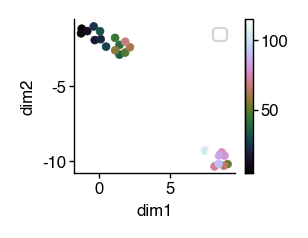

In [49]:
import umap
df=avg_m_norm.copy()

reducer = umap.UMAP(random_state=10,n_neighbors=5, min_dist=0.05)
umap_result = reducer.fit_transform(df)

pcs = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs['age'] = df.index.get_level_values('age')
age_pc = pcs.groupby('age').mean()

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1)

# Scatter plot
im = ax.scatter(
    x=pcs['dim1'], y=pcs['dim2'], 
    c=pcs['age'], 
    cmap='cubehelix',
    s=8,
    linewidth =0.25,
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [10,20,30,40,50]

# Customize the plot
sns.despine()
#plt.title('UMAP Plot of Data females')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend()
plt.show()

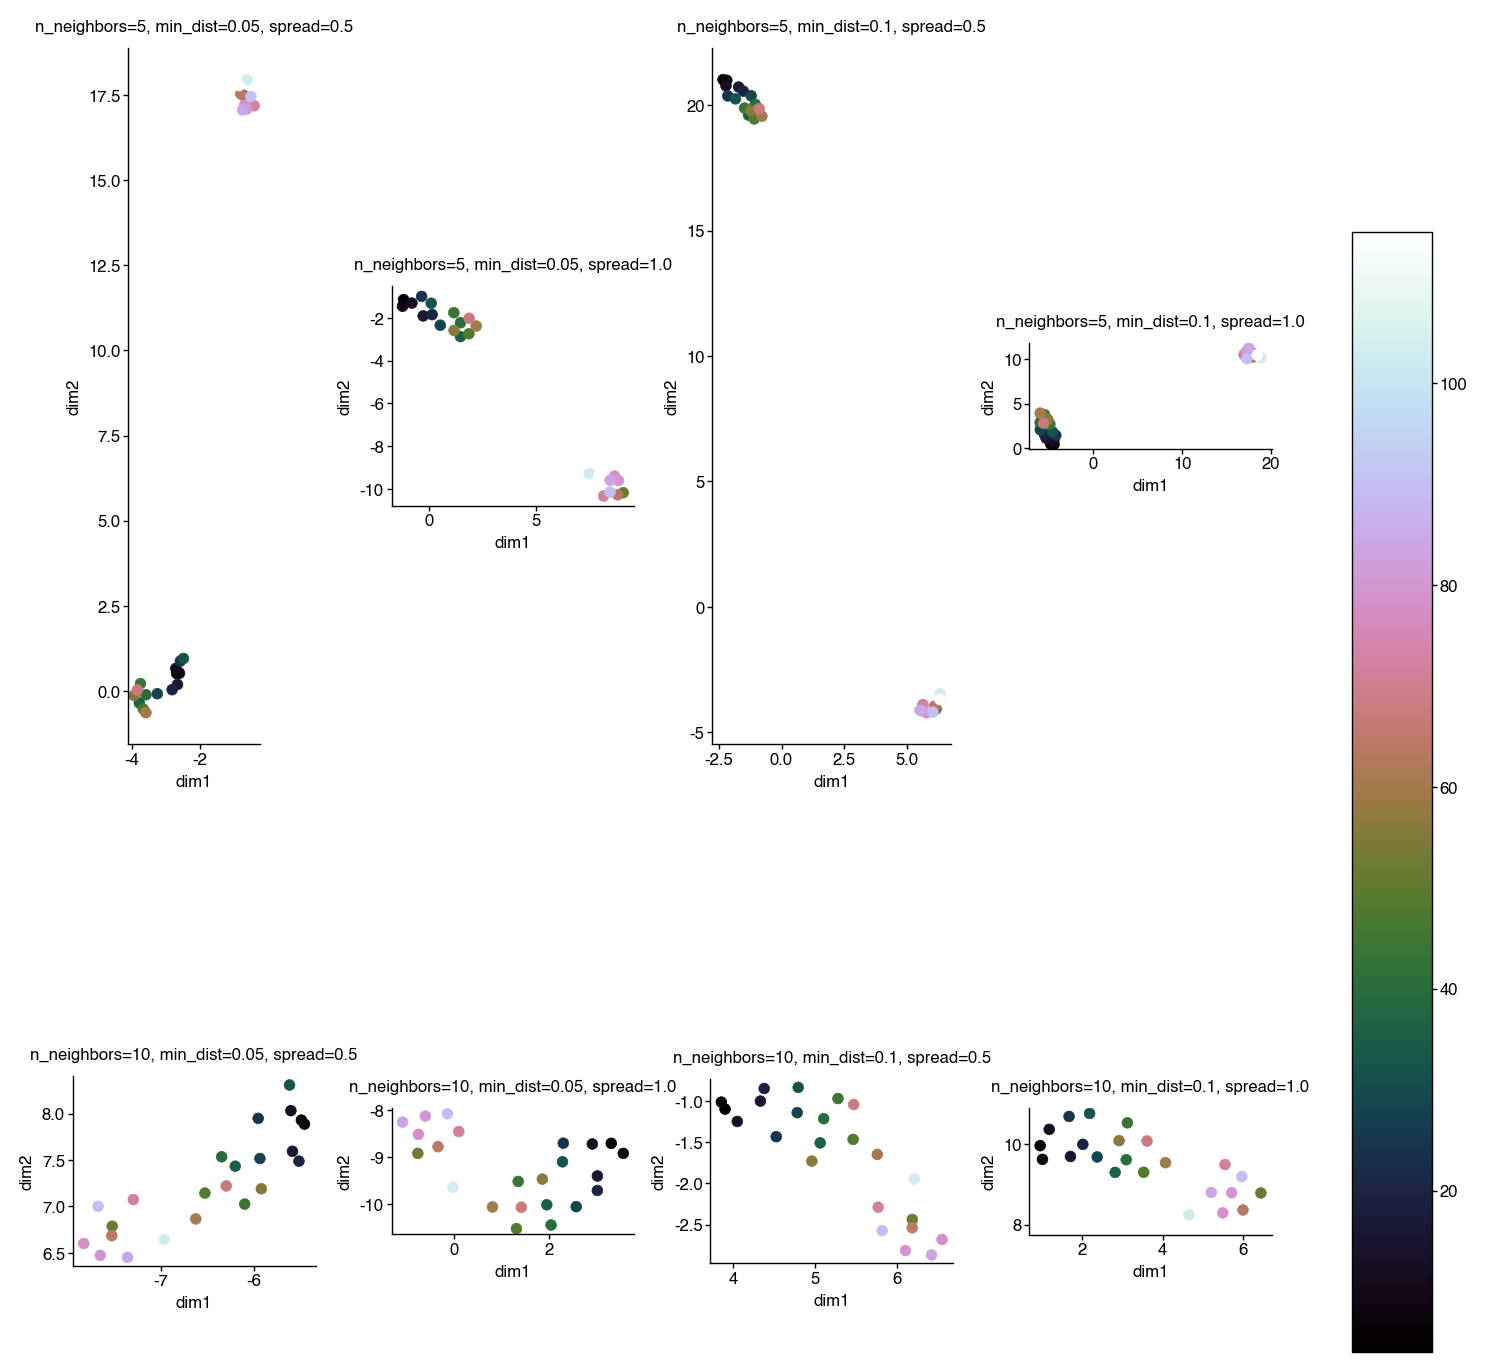

In [50]:
# Assuming avg_m_norm is already defined and is a DataFrame
df = avg_m_norm.copy()

# Define ranges for UMAP parameters
n_neighbors_range = [5,10]
min_dist_range = [0.05, 0.1]
spread_range = [0.5, 1.0]

# Create subplots
fig, axs = plt.subplots(len(n_neighbors_range), len(min_dist_range) * len(spread_range), figsize=(8, 8))
fig.tight_layout(pad=3.0)

# Loop over all combinations of the parameters
for i, n_neighbors in enumerate(n_neighbors_range):
    for j, min_dist in enumerate(min_dist_range):
        for k, spread in enumerate(spread_range):
            ax = axs[i, j * len(spread_range) + k]

            # Initialize UMAP with current parameters
            reducer = umap.UMAP(random_state=10, n_neighbors=n_neighbors, min_dist=min_dist, spread=spread)
            umap_result = reducer.fit_transform(df)

            pcs = pd.DataFrame(umap_result, columns=['dim1', 'dim2'])
            pcs['age'] = df.index.get_level_values('age')

            # Scatter plot
            im = ax.scatter(
                x=pcs['dim1'], y=pcs['dim2'],
                c=pcs['age'],
                cmap='cubehelix',
                s=15,
                linewidth=0.25
            )

            # Customize the plot
            ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread}')
            ax.set_xlabel('dim1')
            ax.set_ylabel('dim2')
            #ax.set_aspect('equal')  # Ensure each panel is square
            sns.despine(ax=ax)

# Add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

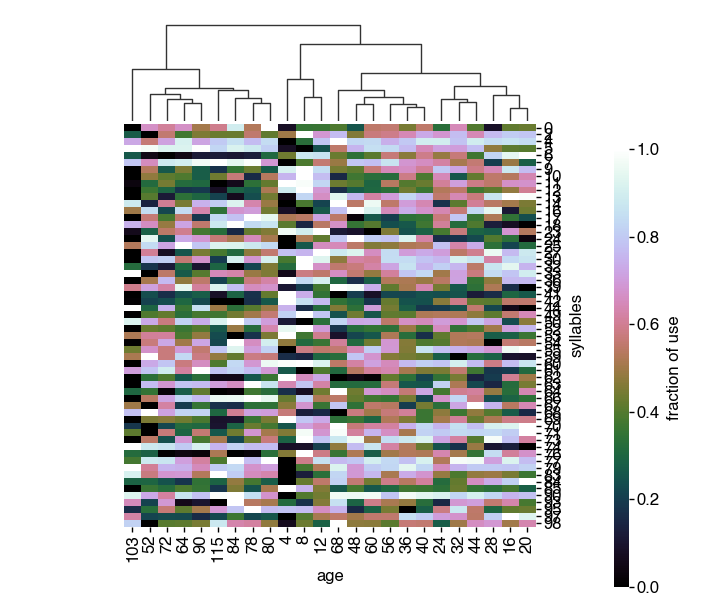

In [66]:
##clustering
# get distance
seqmatcolor='cubehelix'
fdata=avg_m_norm # un-normalized
# kld = squareform(pdist(fdata,metric='cosine'))
kld = pdist(fdata, metric='cosine')
#dm[np.diag_indices_from(dm)] = np.nan
data_labels=fdata.index.get_level_values('age').to_numpy()
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=fdata.T,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    #col_colors=color_mat,
    #row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=True,
    row_cluster=False,
    yticklabels=True,
    xticklabels=True,
    method='ward', metric='euclidean',
    cbar_kws={'label': 'fraction of use'}, 
    )
#cg.ax_row_dendrogram.set_visible(False)
#ax = cg.ax_heatmap
#ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Cut the dendrogram at a specific height to determine clusters
max_d = 1.5  # Maximum height/distance to cut the tree
clusters = fcluster(linkage_matrix, max_d, criterion='distance')

# Add the cluster labels to the DataFrame
df['Cluster'] = clusters

# Print the DataFrame with cluster labels
print(df)

In [37]:
## longtogeny

In [38]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_male = pd.concat([sample,sample2])
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

In [39]:
# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# zscore
z_m = m_df.apply(zscore, axis=0)
avg_z_m = avg_m_df.apply(zscore, axis=0)

# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


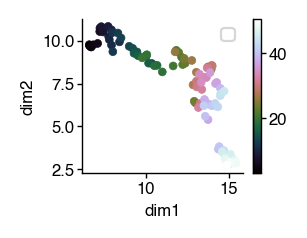

In [40]:
import umap
df=avg_m_norm.copy()

reducer = umap.UMAP(random_state=10,n_neighbors=10, min_dist=0.1)
umap_result = reducer.fit_transform(df)

pcs = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs['age'] = df.index.get_level_values('age')
age_pc = pcs.groupby('age').mean()

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1)

# Scatter plot
im = ax.scatter(
    x=pcs['dim1'], y=pcs['dim2'], 
    c=pcs['age'], 
    cmap='cubehelix',
    s=8,
    linewidth =0.25,
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [10,20,30,40,50]

# Customize the plot
sns.despine()
#plt.title('UMAP Plot of Data females')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend()
plt.show()

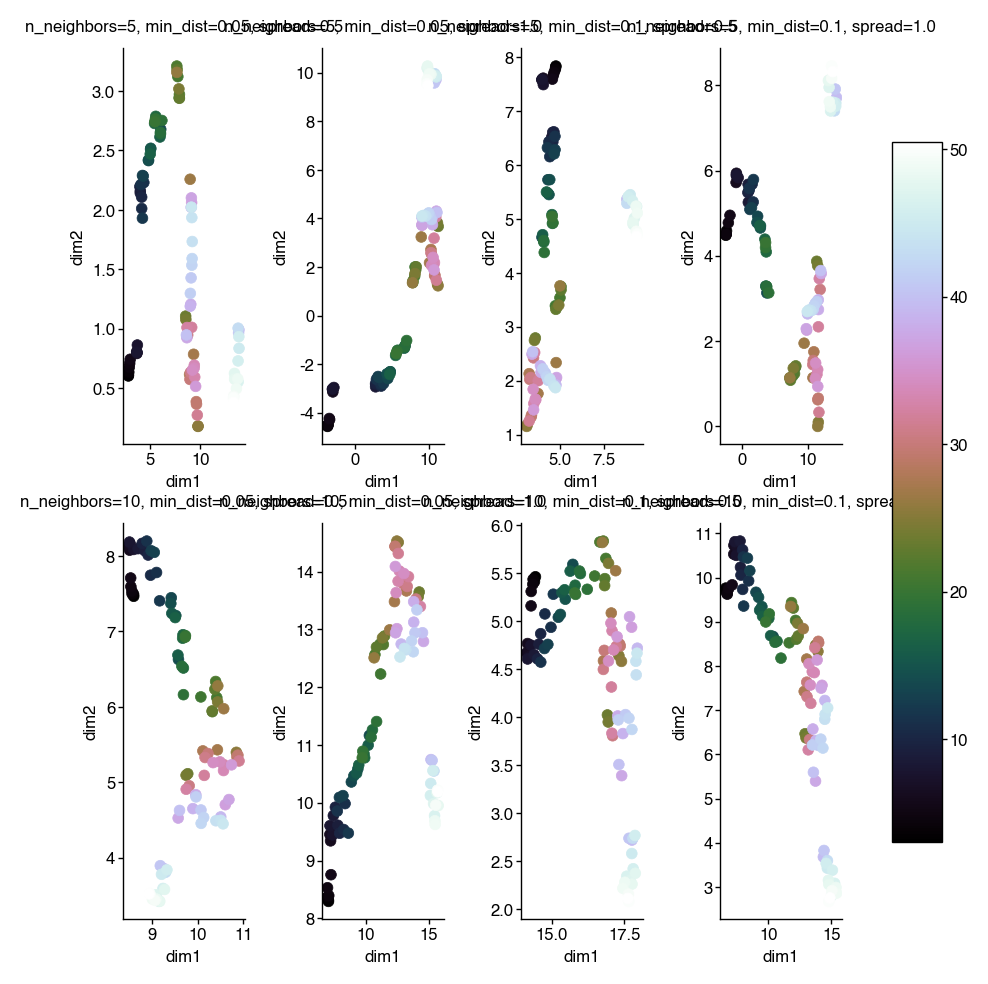

In [42]:
# Assuming avg_m_norm is already defined and is a DataFrame
df = avg_m_norm.copy()

# Define ranges for UMAP parameters
n_neighbors_range = [5,10]
min_dist_range = [0.05, 0.1]
spread_range = [0.5, 1.0]

# Create subplots
fig, axs = plt.subplots(len(n_neighbors_range), len(min_dist_range) * len(spread_range), figsize=(5, 5))
fig.tight_layout(pad=3.0)

# Loop over all combinations of the parameters
for i, n_neighbors in enumerate(n_neighbors_range):
    for j, min_dist in enumerate(min_dist_range):
        for k, spread in enumerate(spread_range):
            ax = axs[i, j * len(spread_range) + k]

            # Initialize UMAP with current parameters
            reducer = umap.UMAP(random_state=10, n_neighbors=n_neighbors, min_dist=min_dist, spread=spread)
            umap_result = reducer.fit_transform(df)

            pcs = pd.DataFrame(umap_result, columns=['dim1', 'dim2'])
            pcs['age'] = df.index.get_level_values('age')

            # Scatter plot
            im = ax.scatter(
                x=pcs['dim1'], y=pcs['dim2'],
                c=pcs['age'],
                cmap='cubehelix',
                s=15,
                linewidth=0.25
            )

            # Customize the plot
            ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread}')
            ax.set_xlabel('dim1')
            ax.set_ylabel('dim2')
            sns.despine(ax=ax)

# Add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [ ]:
## clustering